In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt

from tn_gradient.layer.sow import SoWLinear
from tn_gradient.prepare import accumulate

In [3]:
def inside_row(A, B):
    A = A.detach().cpu().numpy()
    B = B.detach().cpu().numpy()
    
    _, S, _ = np.linalg.svd(A)
    rank = np.sum(S > 1e-5)

    # print(A.shape, B.shape)
    AB = np.vstack((A, B))
    _, S_b, _ = np.linalg.svd(AB)
    rank_b = np.sum(S_b > 1e-5)

    return rank == rank_b


In [4]:
class LinearRegressionModel(nn.Module):
    def __init__(self, n_input_features, n_output_features):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(n_input_features, n_output_features)

    def forward(self, x):
        return self.linear(x)
    
class SoWLinearRegressionModel(nn.Module):
    def __init__(self, n_input_features, n_output_features, rank, n_iter):
        super(SoWLinearRegressionModel, self).__init__()
        self.linear = SoWLinear(
            n_input_features, n_output_features,
            rank=rank, n_iter=n_iter,
            bias=False
        )

    def forward(self, x):
        return self.linear(x)

In [138]:
in_dim = 64
out_dim = 48
batch_size = 1
n_samples = 100000
W = torch.tensor(np.random.randn(in_dim, out_dim), dtype=torch.float32).to('cuda')
b = torch.tensor(np.random.randn(out_dim), dtype=torch.float32).to('cuda')

x_trains = torch.tensor(np.random.randn(n_samples, in_dim), dtype=torch.float32).to('cuda')
y_trains = (torch.mm(x_trains, W) + b).to('cuda')

losses = []

rank = 20
n_iter = 1
learning_rate = 0.015
model = SoWLinearRegressionModel(in_dim, out_dim, rank=rank, n_iter=n_iter).to('cuda')
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

ranks_A, ranks_B = [], []
Bx = []
rowA, colA, rowB, colB = [], [], [], []
prev = torch.zeros_like(y_trains[0])
orth = []
colBt0 = []
rowBt0 = []

A0 = model.linear.downscale_weights[0].clone()
B0 = model.linear.upscale_weights[0].clone()

print(A0.shape, B0.shape)

torch.Size([64, 20]) torch.Size([20, 48])


In [139]:
num_steps = 50*5
acc_step = 50

for step in range(num_steps):
    rand_idx = np.random.randint(0, n_samples, batch_size)
    x_train, y_train = x_trains[rand_idx], y_trains[rand_idx]

    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)

    UA, SA, VA = torch.linalg.svd(model.linear.downscale_weights[0])
    UB, SB, VB = torch.linalg.svd(model.linear.upscale_weights[0])

    ranks_A.append((SA > 1e-5).sum().item())
    ranks_B.append((SB > 1e-5).sum().item())

    dLdy = 1/2 * (x_train @ (model.linear.downscale_weights[0] @ model.linear.upscale_weights[0]) - y_train).squeeze()
    orth.append(torch.dot(dLdy, prev))
    prev = dLdy
    # Bx.append((x_train @ (model.linear.upscale_weights[0] - B0)).detach().cpu().numpy())

    B, A = model.linear.upscale_weights[0], model.linear.downscale_weights[0]
    rowA.append(inside_row(A, B @ dLdy.T))
    colA.append(inside_row(A.T, x_train))
    rowB.append(inside_row(B, dLdy))
    colB.append(inside_row(B.T, x_train @ A))
    # rowA_Bx.append(inside_row(model.linear.upscale_weights[0].T, (x_train @ model.linear.downscale_weights[0])))
    # rowB_x.append(inside_row(model.linear.downscale_weights[0].T, x_train))
    # colA_d.append(inside_row(model.linear.upscale_weights[0], dLdy.unsqueeze(0)))
    # colB_Ad.append(inside_row(model.linear.downscale_weights[0], (model.linear.upscale_weights[0] @ dLdy).unsqueeze(0)))

    rowBt0.append(inside_row(B, B0))
    colBt0.append(inside_row(B.T, B0.T))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if step % acc_step == 0 and step > 0:
        print("-- Model accumulation --")
        accumulate(model)

        A0 = model.linear.downscale_weights[0].clone()
        B0 = model.linear.upscale_weights[0].clone()
        

-- Model accumulation --
-- Model accumulation --
-- Model accumulation --
-- Model accumulation --


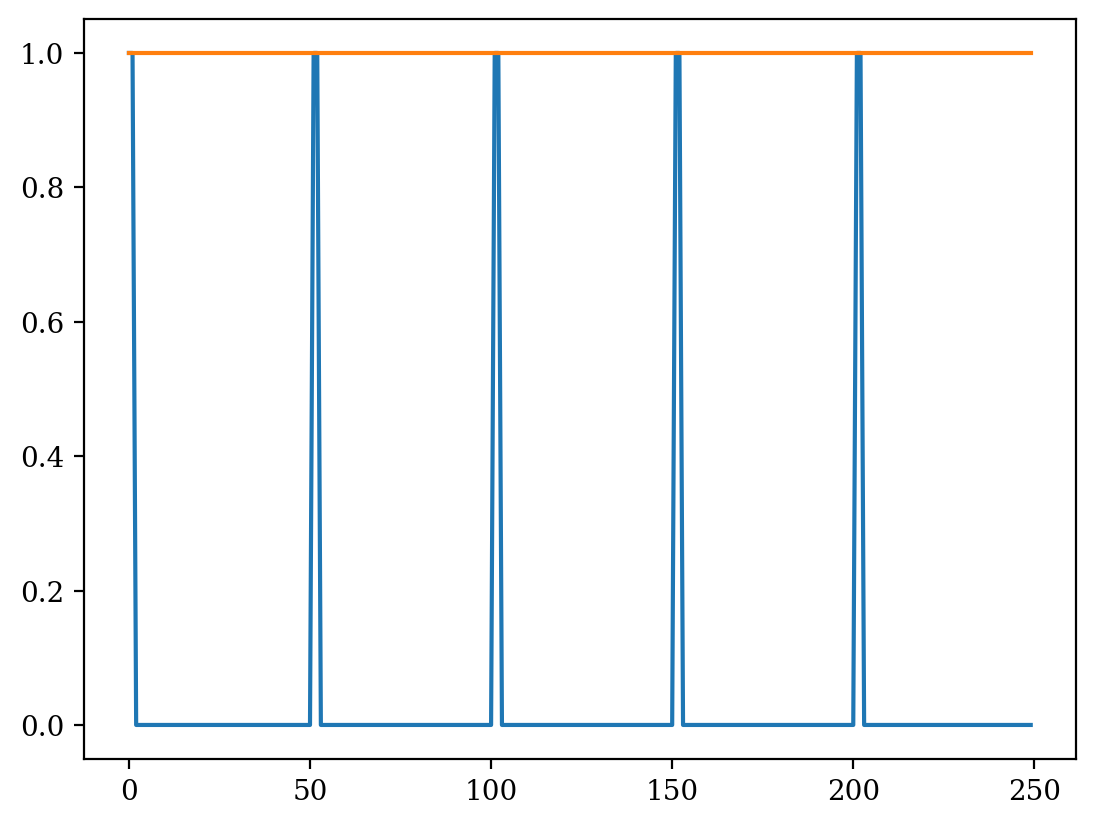

In [141]:
plt.plot(rowBt0)
plt.plot(colBt0)

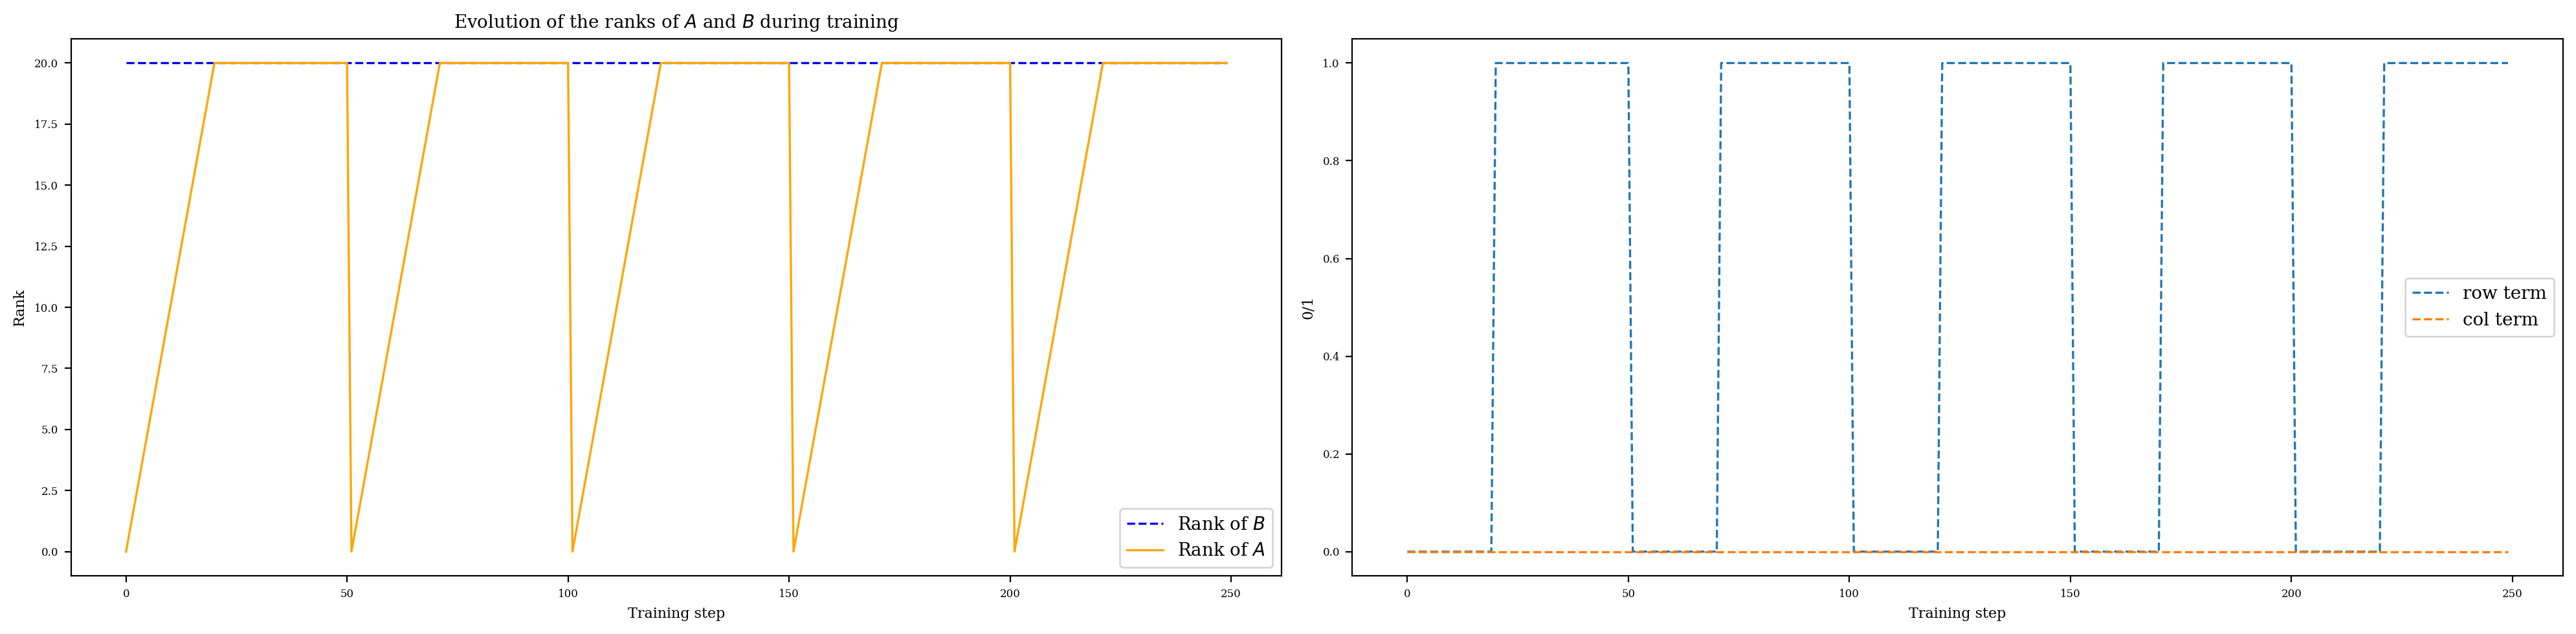

In [142]:
import matplotlib
# matplotlib.use("pgf")

plt.rcParams.update({
    # "pgf.texsystem": "pdflatex",
    # 'text.usetex': True,
    # 'pgf.rcfonts': False,
    'font.family': 'serif',
    'figure.dpi': 200,
})
plt.close()


fig, axes = plt.subplots(1, 2, figsize=(20, 5))

# for i in range(1, 5):
#     axes[0].axvline(60*i, color="black", linestyle="--", lw=0.8)
axes[0].plot(ranks_B, color="blue", linestyle="--", lw=1.2, label=r"Rank of $B$")
axes[0].plot(ranks_A, color="orange", linestyle="-", lw=1.2, label=r"Rank of $A$")
axes[0].legend(fontsize=10, loc='lower right', ncol=1)
axes[0].set_xlabel("Training step", fontsize=8)
axes[0].set_ylabel("Rank", fontsize=8)
axes[0].tick_params(axis='both', which='major', labelsize=6)
axes[0].set_title(r"Evolution of the ranks of $A$ and $B$ during training", fontsize=10)

# additional_xticks = np.arange(60, 300, 60)
# axes[0].set_xticks(additional_xticks, minor=True)
# axes[0].tick_params(axis='x', which='minor', colors='red')
# for tick in additional_xticks:
#     axes[0].annotate(f'{tick}', xy=(tick, 0), xytext=(0, -23), textcoords='offset points', color='red', ha='center', fontsize=6)


# axes[1].plot(rowA_Bx, linestyle="--", lw=1.2)
# axes[1].plot(rowB_x, linestyle="--", lw=1.2)
axes[1].plot(rowB, linestyle="--", lw=1.2, label="row term")
axes[1].plot(colB, linestyle="--", lw=1.2, label="col term")
# axes[1].plot(colA_d, linestyle="--", lw=1.2)
axes[1].set_xlabel("Training step", fontsize=8)
axes[1].set_ylabel(r"0/1", fontsize=8)
axes[1].tick_params(axis='both', which='major', labelsize=6)
axes[1].legend()
# axes[1].set_title(r"$\text{dim}(\text{row}(A) \cap \text{span}(\\{Bx\\}))$", fontsize=10)

# additional_xticks = np.arange(60, 300, 60)
# axes[1].set_xticks(additional_xticks, minor=True)
# axes[1].tick_params(axis='x', which='minor', colors='red')
# for tick in additional_xticks:
#     axes[1].annotate(f'{tick}', xy=(tick, 0), xytext=(0, -23), textcoords='offset points', color='red', ha='center', fontsize=6)

plt.tight_layout()
# plt.savefig('rankAB.pgf')


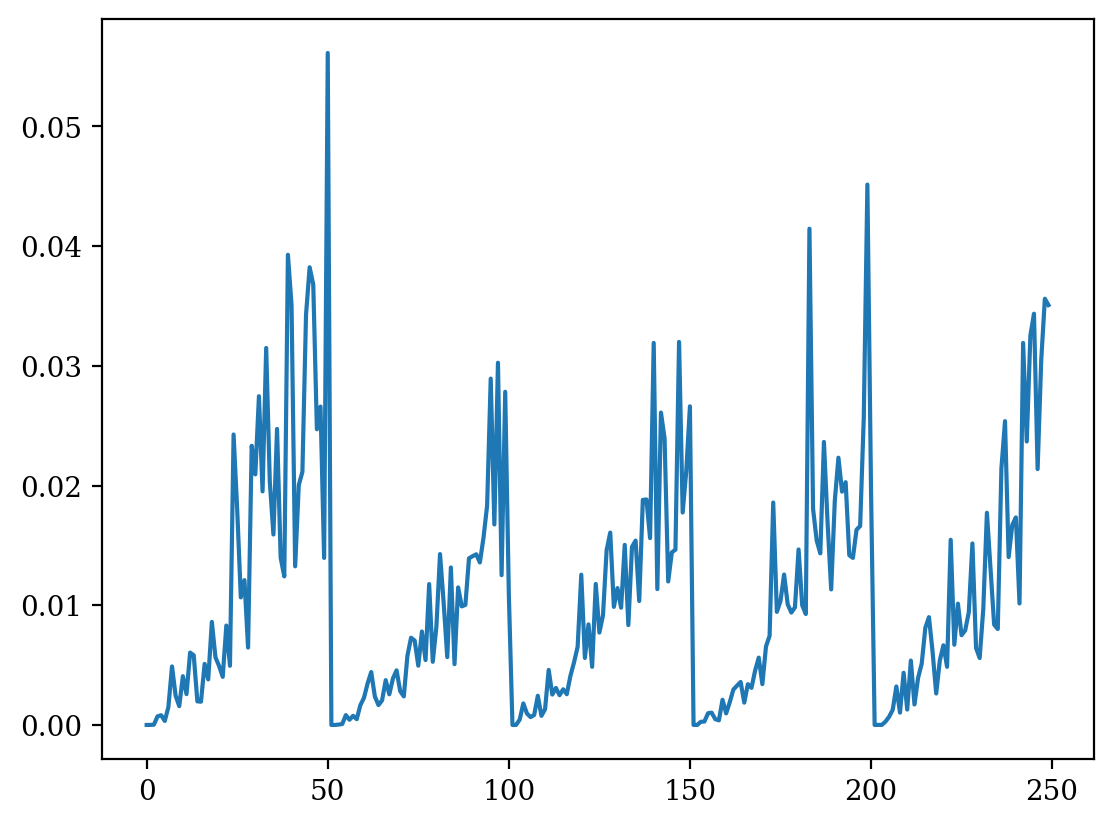

In [57]:
Bx_m = [np.abs(b).mean() for b in Bx]
plt.plot(Bx_m)

In [58]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import os
import copy

from tn_gradient.utils import qr_weight

os.environ["CUDA_VISIBLE_DEVICES"] = "9"


import matplotlib.pyplot as plt

from tn_gradient.layer.sow import SoWLinear
from tn_gradient.prepare import accumulate

class MultiLinearRegressionModel(nn.Module):
    def __init__(self, feature_list, bias=False, init_type="xavier"):
        super(MultiLinearRegressionModel, self).__init__()
        linears = []
        for i in range(len(feature_list) - 2):
            linears.append(nn.Linear(feature_list[i], feature_list[i+1], bias=bias))
            linears.append(nn.ReLU())
        linears.append(nn.Linear(feature_list[-2], feature_list[-1], bias=bias))
        self.linears = nn.Sequential(*linears)
        
        self._initialize_weights(init_type)

    def _initialize_weights(self, init_type):
        # Iterate over each layer in the sequential module
        for layer in self.linears:
            if isinstance(layer, nn.Linear):
                if init_type == "xavier":
                    # Xavier/Glorot Initialization (Uniform)
                    init.xavier_uniform_(layer.weight)
                elif init_type == "he":
                    # He/Kaiming Initialization (Normal)
                    init.kaiming_normal_(layer.weight, nonlinearity='relu')

                # Optionally initialize biases to zeros
                if layer.bias is not None:
                    init.constant_(layer.bias, 0.0)

    def forward(self, x):
        for linear in self.linears:
            x = linear(x)
        return x

class MultiSoWLinearRegressionModel(nn.Module):
    def __init__(self, feature_list, rank, n_iter, bias=False, init_type="xavier"):
        super(MultiSoWLinearRegressionModel, self).__init__()
        linears = []
        for i in range(len(feature_list) - 2):
            linears.append(SoWLinear(feature_list[i], feature_list[i+1], rank=rank, n_iter=n_iter, bias=bias))
            linears.append(nn.ReLU())
        linears.append(SoWLinear(feature_list[-2], feature_list[-1], rank=rank, n_iter=n_iter, bias=bias))
        self.linears = nn.Sequential(*linears)
        self._initialize_weights(init_type)

    def _initialize_weights(self, init_type):
        # Iterate over each layer in the sequential module
        for layer in self.linears:
            if isinstance(layer, SoWLinear):
                weight = torch.zeros((layer.in_features, layer.out_features))                

                for uw, dw in zip(layer.upscale_weights, layer.downscale_weights):
                    if init_type == "xavier":
                        init.xavier_uniform_(dw)
                        init.xavier_uniform_(uw)
                    elif init_type == "he":
                        init.kaiming_normal_(dw, nonlinearity='relu')
                        init.kaiming_normal_(uw, nonlinearity='relu')
                    elif init_type == "qr":
                        nn.init.normal_(weight, mean=0.0, std=0.02) # hardcoded value std=0.02 from Llama config
                        q_weight, r_weight = qr_weight(weight, layer.rank)
                        dw, uw = q_weight, r_weight

                if layer.bias is not None:
                    init.constant_(layer.bias, 0.0)

    def forward(self, x):
        for linear in self.linears:
            x = linear(x)
        return x
    
def sphericalize(model):
    for n, layer in model.named_modules():
        if isinstance(layer, nn.Linear):
            with torch.no_grad():
                weight_norm = torch.linalg.norm(layer.weight, ord='fro')
                if weight_norm > 1.0:
                    layer.weight /= weight_norm
                    layer.weight *= torch.rand(1, 1).to(layer.weight.device)
                
                if layer.bias is not None:
                    bias_norm = torch.linalg.norm(layer.bias, ord=2)
                    if bias_norm > 1.0: layer.bias /= bias_norm
        if isinstance(layer, SoWLinear):
            with torch.no_grad():
                for weight1, weight2 in zip(layer.downscale_weights, layer.upscale_weights):
                    weight_norm1 = torch.linalg.norm(weight1, ord='fro')
                    weight_norm2 = torch.linalg.norm(weight2, ord='fro')
                    if weight_norm1 > 1.0:
                        weight1 /= weight_norm1
                        weight1 *= torch.rand(1, 1).to(weight1.device)
                    if weight_norm2 > 1.0:
                        weight2 /= weight_norm2
                        weight2 *= torch.rand(1, 1).to(weight2.device)
                
                if layer.bias is not None:
                    bias_norm = torch.linalg.norm(layer.bias, ord=2)
                    if bias_norm > 1.0: layer.bias /= bias_norm

def low_rank_approximation(model, rank):
    new_model = copy.deepcopy(model)
    
    for name, layer in new_model.named_modules():
        if isinstance(layer, nn.Linear):
            Q, R = torch.linalg.qr(layer.weight.data)
            Q_r = Q[:, :rank]
            R_r = R[:rank, :]
                        
            new_layer = nn.Linear(layer.in_features, layer.out_features, bias=layer.bias is not None)
            new_layer.weight.data = Q_r @ R_r

            if layer.bias is not None:
                new_layer.bias.data = layer.bias.data
            if "." in name:
                parent_name, child_name = name.rsplit(".", 1)
                parent_module = dict(new_model.named_modules())[parent_name]
                setattr(parent_module, child_name, new_layer)
            else:
                setattr(new_model, name, new_layer)
    
    return new_model

In [82]:
in_dim = 64
out_dim = 64
inner_dim = 64
batch_size = 64
n_samples = 4096

depth = 1
features = [in_dim] + [inner_dim] * (depth-1) + [out_dim]

rank = 20
n_iter = 1
learning_rate = 1e-4
model = MultiSoWLinearRegressionModel(features, rank=rank, n_iter=n_iter, init_type="qr").to('cuda')
# model = MultiLinearRegressionModel(features).to('cuda')
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_model = MultiLinearRegressionModel(features, init_type="he").to('cuda')
train_model.eval()

# Spherical assumptions
sphere = False
if sphere:
    sphericalize(train_model)
    sphericalize(model)

x_trains = torch.tensor(np.random.randn(n_samples, in_dim), dtype=torch.float32).to('cuda')
x_vals = torch.tensor(np.random.randn(n_samples//1000, in_dim), dtype=torch.float32).to('cuda')
if sphere:
    x_norms = torch.linalg.norm(x_trains, dim=1, ord=2, keepdim=True)
    x_trains /= x_norms
    scales = torch.rand(n_samples, 1).to('cuda')
    x_trains *= scales
    
    x_norms = torch.linalg.norm(x_vals, dim=1, ord=2, keepdim=True)
    x_vals /= x_norms
    scales = torch.rand(n_samples, 1).to('cuda')
    x_vals *= scales
# x_trains = torch.where(x_norms > 1.0, x_trains / x_norms, x_trains)
y_trains = train_model(x_trains).detach().to('cuda')
y_vals = train_model(x_vals).detach().to('cuda')

In [93]:
mse_by_depth = {}
in_dim, inner_dim, out_dim = 256, 256, 256
x_trains = torch.tensor(np.random.randn(n_samples, in_dim), dtype=torch.float32).to('cuda')

for depth in [1, 2, 4, 6, 8, 10, 15, 20]:
    print("Depth", depth)
    features = [in_dim] + [inner_dim] * (depth-1) + [out_dim]
    
    train_model = MultiLinearRegressionModel(features, init_type="he").to('cuda')
    train_model.eval()
    # sphericalize(train_model)

    diff = []
    for rank in range(1, inner_dim):
        low_rank_model = low_rank_approximation(train_model, rank=rank)
        diff.append(criterion(low_rank_model(x_trains), train_model(x_trains)).item())
    mse_by_depth[depth] = diff

Depth 1
Depth 2
Depth 4
Depth 6
Depth 8
Depth 10
Depth 15
Depth 20


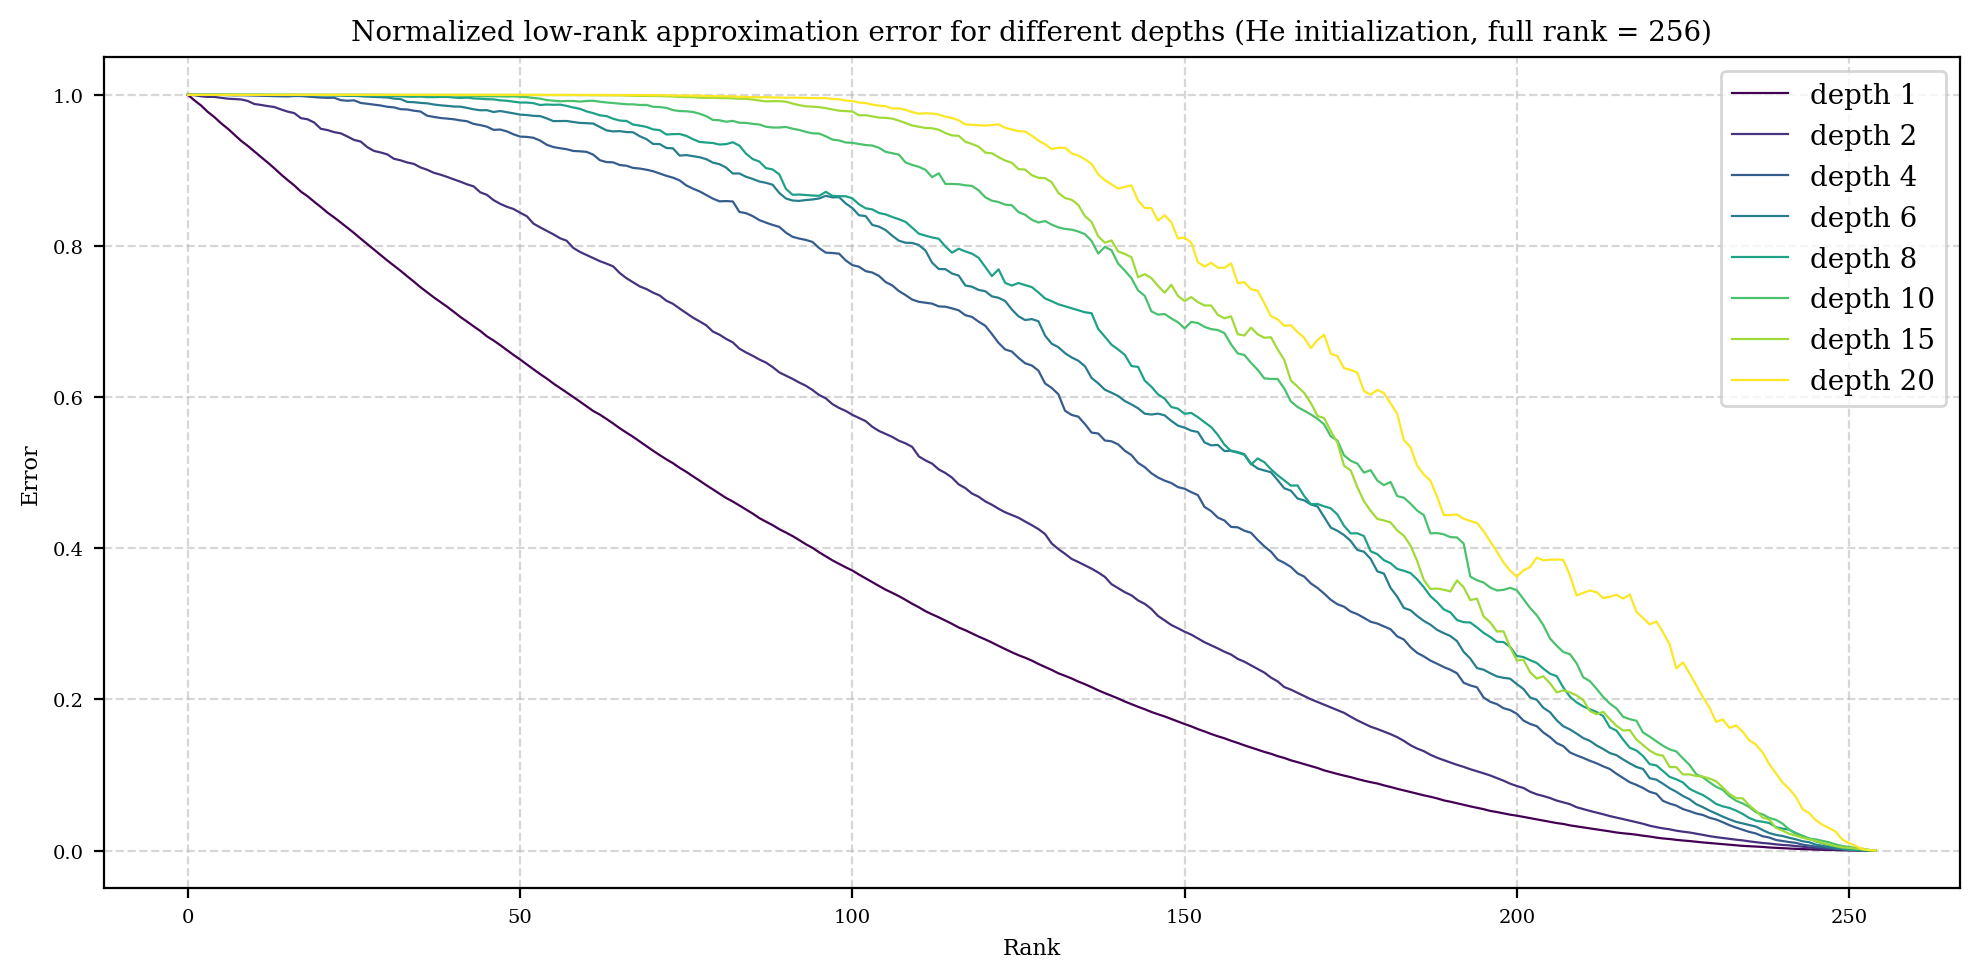

In [104]:
plt.rcParams["figure.dpi"] = 200
plt.rcParams['font.family'] = 'serif'

plt.figure(figsize=(10, 5))

palette = plt.get_cmap('viridis', len(mse_by_depth))
for i, (k,v) in enumerate(mse_by_depth.items()):
    plt.plot([vv / v[0] for vv in v], label=f"depth {k}", lw=0.8, color=palette(i))

plt.xlabel("Rank", fontsize=8)
plt.ylabel("Error", fontsize=8)
plt.title(f"Normalized low-rank approximation error for different depths (He initialization, full rank = 256)", fontsize=10)
plt.legend(fontsize=6, loc='upper right', ncol=3)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.legend()
plt.tight_layout()
plt.savefig("lwerr_he.pgf")

In [100]:
mse_by_depth_xavier = {}
in_dim, inner_dim, out_dim = 256, 256, 256
x_trains = torch.tensor(np.random.randn(n_samples, in_dim), dtype=torch.float32).to('cuda')

for depth in [1, 2, 4, 6, 8, 10, 15, 20]:
    print("Depth", depth)
    features = [in_dim] + [inner_dim] * (depth-1) + [out_dim]
    
    train_model = MultiLinearRegressionModel(features, init_type="xavier").to('cuda')
    train_model.eval()

    diff = []
    for rank in range(1, inner_dim):
        low_rank_model = low_rank_approximation(train_model, rank=rank)
        diff.append(criterion(low_rank_model(x_trains), train_model(x_trains)).item())
    mse_by_depth_xavier[depth] = diff

Depth 1
Depth 2
Depth 4
Depth 6
Depth 8
Depth 10
Depth 15
Depth 20


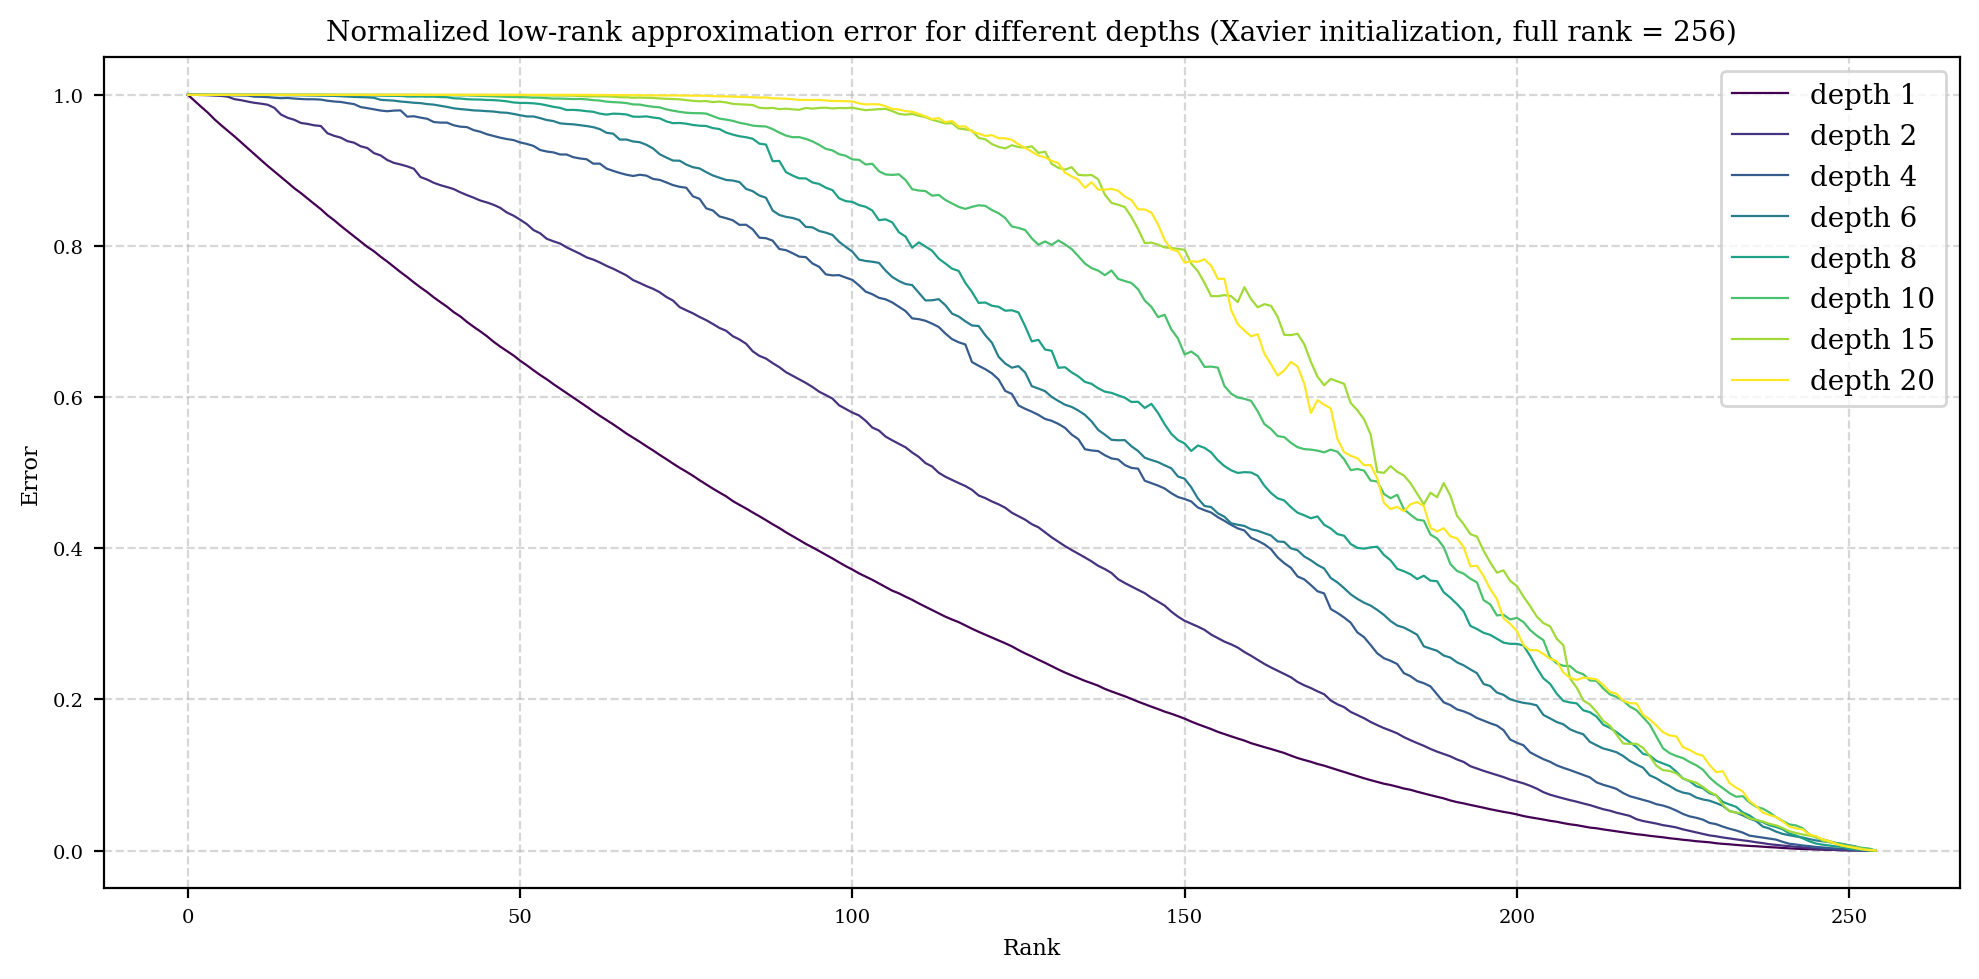

In [105]:
plt.rcParams["figure.dpi"] = 200
plt.rcParams['font.family'] = 'serif'

plt.figure(figsize=(10, 5))

palette = plt.get_cmap('viridis', len(mse_by_depth_xavier))
for i, (k,v) in enumerate(mse_by_depth_xavier.items()):
    plt.plot([vv / v[0] for vv in v], label=f"depth {k}", lw=0.8, color=palette(i))

plt.xlabel("Rank", fontsize=8)
plt.ylabel("Error", fontsize=8)
plt.title(f"Normalized low-rank approximation error for different depths (Xavier initialization, full rank = 256)", fontsize=10)
plt.legend(fontsize=6, loc='upper right', ncol=3)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=7)
plt.legend()
plt.tight_layout()
plt.savefig("lwerr_xavier.pgf")

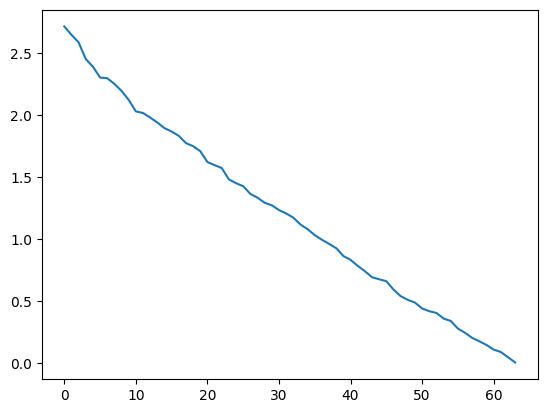

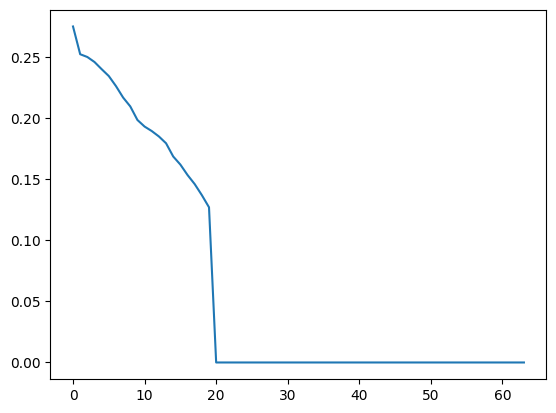

In [79]:
singular_values = []
singular_values_2 = []
for n, layer in train_model.named_modules():
    if isinstance(layer, nn.Linear):
        with torch.no_grad():
            _, S, _ = torch.linalg.svd(layer.weight)
            singular_values.append(list(S.detach().cpu().numpy()))
for n, layer in model.named_modules():
    if isinstance(layer, SoWLinear):
        with torch.no_grad():
            _, S, _ = torch.linalg.svd(layer.downscale_weights[0] @ layer.upscale_weights[0])
            singular_values_2.append(list(S.detach().cpu().numpy()))

for sv in singular_values:
    plt.plot(sv)
plt.show()
for sv in singular_values_2:
    plt.plot(sv)
plt.show()

In [83]:
U, S, V = torch.linalg.svd(x_trains @ train_model.linears[0].weight.T)
U2, S2, V2 = torch.linalg.svd(train_model.linears[0].weight.T)

In [84]:
print(V[:rank, :].shape)
print((model.linears[0].downscale_weights[0] @ model.linears[0].upscale_weights[0]))
print(train_model.linears[0].weight.T @ V[:rank, :].T @ V[:rank, :])
print(torch.linalg.matrix_rank(train_model.linears[0].weight.T @ V[:rank, :].T @ V[:rank, :]))
# print(train_model.linears[0].bias)
print(torch.linalg.norm(train_model(x_trains), ord="fro"))
print(torch.linalg.norm(train_model(x_trains) - x_trains @ train_model.linears[0].weight.T @ V[:rank, :].T @ V[:rank, :], ord="fro"))
print(torch.linalg.norm(train_model(x_trains) - x_trains @ U2[:, :rank] @ torch.diag(S2[:rank]) @ V2[:rank, :], ord="fro"))
print(torch.linalg.norm(train_model(x_trains) - x_trains @ model.linears[0].downscale_weights[0] @ model.linears[0].upscale_weights[0], ord="fro"))

torch.Size([20, 64])
tensor([[-4.3950e-03,  4.4527e-02,  1.8829e-02,  ...,  1.0873e-02,
          1.1468e-02,  2.3034e-02],
        [ 1.1015e-03, -2.3392e-02,  7.1310e-03,  ..., -2.5478e-02,
         -1.4756e-02, -2.1596e-02],
        [ 4.6905e-03, -7.6467e-03, -1.6025e-02,  ...,  9.8587e-04,
          2.7953e-03, -4.0208e-03],
        ...,
        [ 2.3973e-02, -1.1340e-02,  1.7626e-04,  ...,  1.1826e-03,
         -1.6971e-02, -1.2600e-02],
        [-1.6604e-03,  1.4099e-02, -1.1475e-02,  ...,  7.4181e-03,
          6.6221e-03,  7.7000e-05],
        [-9.4182e-03, -2.9660e-02, -4.2526e-02,  ...,  4.9355e-03,
         -1.5928e-02, -1.0764e-02]], device='cuda:0', grad_fn=<MmBackward0>)
tensor([[-0.0240,  0.0941,  0.0640,  ...,  0.1504,  0.0543,  0.0835],
        [-0.2958, -0.1810,  0.2272,  ...,  0.0771,  0.0130,  0.2738],
        [-0.0135,  0.0459, -0.1200,  ..., -0.0825, -0.0443,  0.0305],
        ...,
        [ 0.1399, -0.0675, -0.1404,  ..., -0.0818, -0.0729,  0.0250],
        [ 0.30

[1/10000] loss = 2.0396,
[201/10000] loss = 1.8740,
[401/10000] loss = 1.7359,
[601/10000] loss = 1.5877,
[801/10000] loss = 1.4129,
[1001/10000] loss = 1.2430,
[1201/10000] loss = 1.1367,
[1401/10000] loss = 1.0275,
[1601/10000] loss = 0.8780,
[1801/10000] loss = 0.8562,
[2001/10000] loss = 0.7685,
[2201/10000] loss = 0.7487,
[2401/10000] loss = 0.6929,
[2601/10000] loss = 0.6590,
[2801/10000] loss = 0.5994,
[3001/10000] loss = 0.6059,
[3201/10000] loss = 0.5586,
[3401/10000] loss = 0.5550,
[3601/10000] loss = 0.5283,
[3801/10000] loss = 0.5196,
[4001/10000] loss = 0.4908,
[4201/10000] loss = 0.5229,
[4401/10000] loss = 0.4831,
[4601/10000] loss = 0.4549,
[4801/10000] loss = 0.4706,
[5001/10000] loss = 0.4889,
[5201/10000] loss = 0.4717,
[5401/10000] loss = 0.4455,
[5601/10000] loss = 0.4484,
[5801/10000] loss = 0.4470,
[6001/10000] loss = 0.4648,
[6201/10000] loss = 0.4467,
[6401/10000] loss = 0.4201,
[6601/10000] loss = 0.4207,
[6801/10000] loss = 0.4535,
[7001/10000] loss = 0.4125,

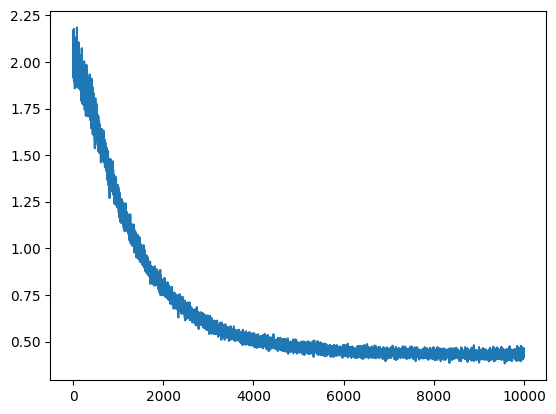

In [68]:
num_steps = 10000
acc_step = 20000*4
log_step = 200
losses = []
eval_losses = []

for step in range(num_steps):
    rand_idx = np.random.randint(0, n_samples, batch_size)
    x_train, y_train = x_trains[rand_idx], y_trains[rand_idx]

    y_pred = model(x_train)

    scaling_factor = torch.max(torch.abs(y_pred)).item()
    # Avoid division by zero in case all predictions are zero
    # if scaling_factor == 0:
    scaling_factor = 1.0

    # Scale predictions and targets
    y_pred_scaled = y_pred / scaling_factor
    y_train_scaled = y_train / scaling_factor

    # loss = criterion(y_pred, y_train)
    loss = criterion(y_pred_scaled, y_train_scaled)

    if step % acc_step == 0 and step > 0:
        print("-- Model accumulation --")

        accumulate(model)
        if model.linears[2].acc_downweight is not None:
            _, S, _ = torch.linalg.svd(model.linears[2].acc_downweight @ model.linears[2].acc_upweight)
            print("Rank", S[S > 1e-5].shape[0])

        group = optimizer.param_groups[0]
        for param in group["params"]:
            state = optimizer.state[param]
            state["exp_avg"] = torch.zeros_like(param, memory_format=torch.preserve_format)
            state["exp_avg_sq"] = torch.zeros_like(param, memory_format=torch.preserve_format)
            if group["amsgrad"]:
                state["max_exp_avg_sq"] = torch.zeros_like(param, memory_format=torch.preserve_format)
            state["step"] = torch.zeros_like(state["step"])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
    losses.append(loss.item())

    if step % log_step == 0:
        # with torch.no_grad():
        #     rand_idx = np.random.randint(0, x_vals.shape[0]-1, batch_size)
        #     x_val, y_val = x_vals[rand_idx], y_vals[rand_idx]
        #     eval_loss = criterion(model(x_val), y_val)
        # eval_losses.append(eval_loss.item())
        print(f"[{step+1}/{num_steps}] loss = {loss.item():.4f},")# eval_loss = {eval_loss.item():.2f}")


import matplotlib.pyplot as plt
plt.plot(losses)
# plt.ylim(0, 1000)

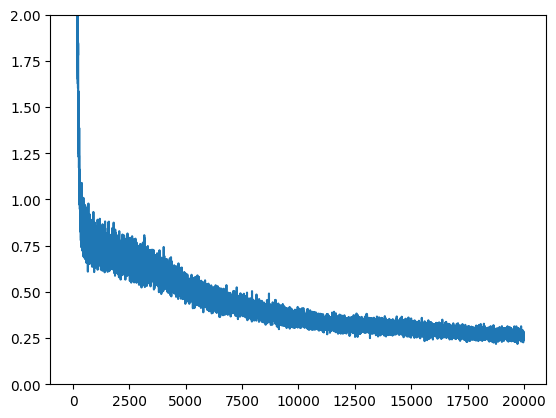

In [65]:
# plt.plot(losses)
plt.plot(losses)
plt.ylim(0, 2)
plt.show()

In [41]:
n_test = 10000
x_test = torch.tensor(np.random.randn(n_test, in_dim), dtype=torch.float32).to('cuda')
if sphere:
    x_test /= torch.linalg.norm(x_test, dim=1, ord=2, keepdim=True)
    x_test *= torch.rand(n_test, 1).to('cuda')
mu = torch.linalg.norm(x_test, dim=1).mean().item()
mu = torch.linalg.norm(x_trains, dim=1).mean().item()
xi, D, m = 0, 0, 0
for n, p in train_model.named_modules():
    if isinstance(p, nn.Linear):
        _, S, _ = torch.linalg.svd(p.weight)
        xi = max(xi, torch.pow(S[rank:], 2).sum().item())
        m = max(m, torch.linalg.norm(p.weight, ord='fro').item())
        D += 1

print(xi, D, m, mu)
criterion(model(x_trains), train_model(x_trains)).item(), xi * (m**2 * (m**(2*D) - 1) / (m**2 - 1)) * mu if m != 1.0 else xi * D * mu
# model(x_test), train_model(x_test), criterion(model(x_test), train_model(x_test)), (model(x_test) - train_model(x_test))/train_model(x_test)

37.888145446777344 5 11.413387298583984 7.9648003578186035


(0.2736179828643799, 11406977172581.629)